# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

In [3]:
torch.manual_seed(params["seed"])

In [4]:
dataset = get_dataset("synthetic2")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  400
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


In [5]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

In [6]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training : 100%|██████████| 12000/12000 [00:25<00:00, 473.19 iteration/s]


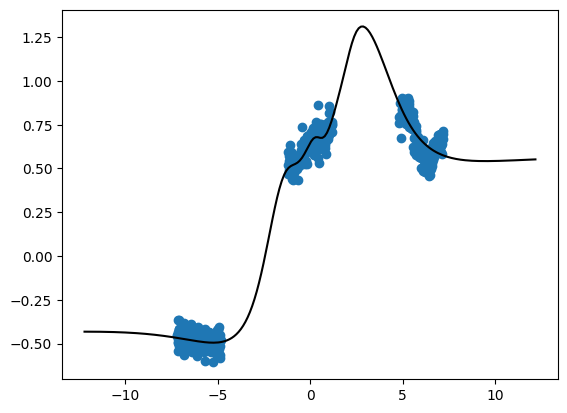

In [7]:
plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

# Quadratic Laplace

In [8]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "quad"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)

In [9]:
la

In [10]:
la.backend

In [12]:
la.backend.last_layer

False

In [13]:
la.fit(train_loader)

Dejar los hiperparam. iguales que los que salen con LLA (después se puede ver si cambian, pero para hacer una comparación más equitativa de primeras).

Probar con los hiperparam sin optimizar y fijos de LLA.

In [14]:
# En principio no hacemos optimización de hiperparámetros
# Dejamos los que han salido mejores en el ejemplo de LLA
prior_std = 2.156211072302787
log_variance = -5.5347821004082105

In [15]:
def distribution_plot(model_predictive, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-2.5 ,5)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("./plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

In [17]:
la.H

tensor([[ 5.8881e+25,  3.1074e+25,  7.6939e+24,  ..., -5.2678e+27,
          1.4028e+27,  1.5612e+27],
        [ 3.1074e+25,  7.6089e+25,  1.8529e+25,  ..., -7.8730e+27,
          2.2026e+27,  8.1192e+27],
        [ 7.6939e+24,  1.8529e+25,  4.5570e+24,  ..., -2.0035e+27,
          5.7217e+26,  2.0592e+27],
        ...,
        [-5.2678e+27, -7.8730e+27, -2.0035e+27,  ...,  1.1091e+30,
         -3.3798e+29, -9.5438e+29],
        [ 1.4028e+27,  2.2026e+27,  5.7217e+26,  ..., -3.3798e+29,
          1.0764e+29,  3.0464e+29],
        [ 1.5612e+27,  8.1192e+27,  2.0592e+27,  ..., -9.5438e+29,
          3.0464e+29,  1.1989e+30]], dtype=torch.float64)

In [16]:
distribution_plot(la._glm_predictive_distribution, "Quadratic")

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 24 is not positive-definite).

<Figure size 1600x700 with 0 Axes>